# 1. Overview

This notebook outlines a process for analyzing ASML stock price data using historical data from Yahoo Finance. Key steps include data cleaning, transformation, and exploratory analysis, such as Seasonal-Trend-Loess (STL) decomposition to identify trends, seasonality, and residuals. Autocorrelation and partial autocorrelation functions (ACF/PACF) are used to explore dependencies over time, suggesting an ARIMA model for forecasting. Additional analyses cover rolling statistics, return distribution, outlier detection, and correlation with the S&P 500, providing a comprehensive overview of the stock's performance and behavior.

# 2. Data Understanding

## 2.1 Data Description

## 2.2 Import necessary libraries

In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import warnings
import pickle

from datetime import datetime, timedelta
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Suppress the SettingWithCopyWarning
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

## 2.3 Define Global Variables

In [2]:
company_name = 'ASML'  # Replace 'ASML' with any other company ticker (e.g., 'AAPL' for Apple)
start_date = '2018-01-01'
output_data = 'data/weekly_data_asml.csv'
start_data_and_test_weeks_path = 'data/start_data_and_test_weeks.pkl'
test_weeks = 12

## 2.4 Functions

In [3]:
def get_historical_data(ticker_symbol:str, start_date:str, end_date:str)->pd.DataFrame:
    """
    Fetches historical stock data for a given company between specified dates. 
    Returns a DataFrame containing the historical data.

    Input:
    - ticker_symbol: The stock ticker of the company (e.g., 'ASML').
    - start_date: The start date for the historical data (e.g., '2000-01-01').
    - end_date: The end date for the historical data (e.g., '2024-10-05').

    Output:
    - A pandas DataFrame containing the historical stock data for the specified period.
    """
    # Define the ticker symbol
    stock_data = yf.Ticker(ticker_symbol)

    # Download historical data between the start and end dates
    historical_data = stock_data.history(start=start_date, end=end_date)

    # Reset the index to convert 'Date' from an index to a regular column
    historical_data.reset_index(inplace=True)

    # Return the resulting DataFrame
    return historical_data

In [4]:
def plot_closing_prices(historical_data:pd.DataFrame, company_name:str):
    """
    Plots the historical closing prices of a company's stock over time.

    Input:
    - historical_data: DataFrame containing the stock data with 'Date' and 'Close' columns.
    - company_name: The name or ticker of the company to be displayed in the plot title.

    Output:
    - A line plot of the company's historical closing prices.
    """
    # Convert the 'Date' and 'Close' columns to numpy arrays
    dates = np.array(historical_data['Date'])
    close_prices = np.array(historical_data['Close'])

    # Create the plot for the 'Close' (closing price) column using matplotlib
    plt.figure(figsize=(10, 6))  # Set the figure size
    plt.plot(dates, close_prices, label='Closing Price', color='blue')

    # Add title and axis labels
    plt.title(f'Historical Closing Prices of {company_name} between {dates[0]} and {dates[-1]}')
    plt.xlabel('Date')
    plt.ylabel('Closing Price (USD)')

    # Rotate X-axis labels for better readability
    plt.xticks(rotation=45)

    # Show the legend
    plt.legend()

    # Adjust layout to prevent overlap of elements
    plt.tight_layout()

    # Display the plot
    plt.show()

In [5]:
# Groupby daily, weekly, and monthly
def plot_stock_by_period(historical_data:pd.DataFrame, company_name:str):
    """
    Input: 
    - historical_data: DataFrame containing stock data with 'Date' and 'Close' columns.
    - company_name: String representing the name of the company.

    Output: 
    - Three line plots showing daily, weekly, and monthly average closing prices.
    - Prints the count of data points for each group (daily, weekly, and monthly).

    Logic: 
    - The function resamples the stock data by day, week, and month, computes the average closing price, 
      and generates line plots using Matplotlib for each resampled dataset.
    """

    # Convert 'Date' column to datetime if not already
    historical_data['Date'] = pd.to_datetime(historical_data['Date'])

    # Set 'Date' as the DataFrame index
    historical_data.set_index('Date', inplace=True)

    # Group by different periods
    daily_data = historical_data.resample('D').median()
    weekly_data = historical_data.resample('W').median()
    monthly_data = historical_data.resample('M').median()

    # Print the number of data points for each period
    print(f"Number of daily data points: {daily_data.shape[0]}")
    print(f"Number of weekly data points: {weekly_data.shape[0]}")
    print(f"Number of monthly data points: {monthly_data.shape[0]}")

    # Convert 'Date' and 'Close' columns to NumPy arrays for matplotlib compatibility
    daily_dates = daily_data.index.to_numpy()
    daily_close_prices = daily_data['Close'].to_numpy()

    weekly_dates = weekly_data.index.to_numpy()
    weekly_close_prices = weekly_data['Close'].to_numpy()

    monthly_dates = monthly_data.index.to_numpy()
    monthly_close_prices = monthly_data['Close'].to_numpy()

    # Plot daily data
    plt.figure(figsize=(10, 6))
    plt.plot(daily_dates, daily_close_prices, label='Daily Closing Price', color='blue')
    plt.title(f'{company_name} - Daily Closing Prices')
    plt.xlabel('Date')
    plt.ylabel('Closing Price (USD)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Plot weekly data
    plt.figure(figsize=(10, 6))
    plt.plot(weekly_dates, weekly_close_prices, label='Weekly Closing Price', color='green')
    plt.title(f'{company_name} - Weekly Closing Prices')
    plt.xlabel('Date')
    plt.ylabel('Closing Price (USD)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Plot monthly data
    plt.figure(figsize=(10, 6))
    plt.plot(monthly_dates, monthly_close_prices, label='Monthly Closing Price', color='red')
    plt.title(f'{company_name} - Monthly Closing Prices')
    plt.xlabel('Date')
    plt.ylabel('Closing Price (USD)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [6]:
def create_daily_date_list(start_date:str, end_date:str)->list:
    """
    Input: start_date and end_date as strings in "YYYY-MM-DD" format
    Output: List of dates between start_date and end_date in "YYYY-MM-DD" format
    Logic: Iterates from start_date to end_date, adding each day to the list in "YYYY-MM-DD" format
    """

    
    # Parse the start and end dates from string format to datetime objects
    start = datetime.strptime(start_date, "%Y-%m-%d")
    end = datetime.strptime(end_date, "%Y-%m-%d")
    
    # Initialize an empty list to store the dates
    date_list = []
    
    # Generate dates by iterating from start to end date with daily frequency
    current_date = start
    while current_date <= end:
        date_list.append(current_date.strftime("%Y-%m-%d"))  # Append date as a string in 'YYYY-MM-DD' format
        current_date += timedelta(days=1)  # Move to the next day

    return date_list

In [7]:
def plot_stock_with_multiple_boxplots(historical_data:pd.DataFrame, company_name:str):
    """
    Plots the stock's closing price distribution for weekly, monthly, and quarterly with
    multiple boxplots for each period.
    
    Input:
    - historical_data: DataFrame containing stock data with 'Date' and 'Close' columns.
    - company_name: String representing the name of the company.
    
    Output:
    - Boxplots for each period (7 for weekly, 12 for monthly, and 4 for quarterly).
    """

    # Ensure 'Date' column is in datetime format
    historical_data['Date'] = pd.to_datetime(historical_data['Date'])

    # Extract additional time period information
    historical_data['Weekday'] = historical_data['Date'].dt.weekday  # Weekday (0=Monday, 6=Sunday)
    historical_data['Month'] = historical_data['Date'].dt.month      # Month (1=January, 12=December)
    historical_data['Quarter'] = historical_data['Date'].dt.quarter  # Quarter (1 to 4)

    # Plot Weekly Data (7 boxplots for each day of the week)
    plt.figure(figsize=(12, 8))
    historical_data.boxplot(column='Close', by='Weekday', grid=True)
    plt.title(f'{company_name} - Weekly Closing Prices (by Weekday)')
    plt.suptitle('')
    plt.xlabel('Weekday (0=Monday, 6=Sunday)')
    plt.ylabel('Closing Price (USD)')
    plt.show();

    # Plot Monthly Data (12 boxplots for each month)
    plt.figure(figsize=(12, 8))
    historical_data.boxplot(column='Close', by='Month', grid=True)
    plt.title(f'{company_name} - Monthly Closing Prices (by Month)')
    plt.suptitle('')
    plt.xlabel('Month')
    plt.ylabel('Closing Price (USD)')
    plt.show();

    # Plot Quarterly Data (4 boxplots for each quarter)
    plt.figure(figsize=(12, 8))
    historical_data.boxplot(column='Close', by='Quarter', grid=True)
    plt.title(f'{company_name} - Quarterly Closing Prices (by Quarter)')
    plt.suptitle('')
    plt.xlabel('Quarter')
    plt.ylabel('Closing Price (USD)')
    plt.show();


In [8]:
def get_last_friday():
    """
    Input: No arguments; the function uses the current date as the starting point.
    Output: Returns `end_date` as a string formatted as `YYYY-MM-DD`, representing the last Friday's date.
    Logic: Calculate the number of days back to the last Friday.    
    
    """
    today = datetime.today()
    # Calculate the number of days back to the last Friday
    days_back = (today.weekday() - 4) % 7
    last_friday = today - timedelta(days=days_back)
    end_date = last_friday.strftime("%Y-%m-%d")
    return end_date


end_date = get_last_friday()

## 2.5 Code

### 2.5.1 Looking at the dataset

We are going to load the data using the function get_historical_data

In [9]:
# Call the function get_historical_data
historical_data = get_historical_data(company_name, start_date, end_date)

# Convert 'Date' column to datetime format and keep only the date (without time)
historical_data['Date'] = pd.to_datetime(historical_data['Date']).dt.date

historical_data

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2018-01-02,162.389805,165.840142,162.240597,165.737564,818600,0.0,0.0
1,2018-01-03,165.737577,167.462753,165.690948,166.996490,1054200,0.0,0.0
2,2018-01-04,168.311351,169.504981,167.294889,168.553802,915600,0.0,0.0
3,2018-01-05,168.637723,171.071612,168.553799,170.530746,516100,0.0,0.0
4,2018-01-08,170.829180,172.013490,170.474816,171.425995,763900,0.0,0.0
...,...,...,...,...,...,...,...,...
1730,2024-11-15,678.359985,679.880005,657.520020,658.630005,3063200,0.0,0.0
1731,2024-11-18,651.070007,668.859985,648.000000,665.229980,2012600,0.0,0.0
1732,2024-11-19,662.820007,671.409973,653.469971,662.159973,1640700,0.0,0.0
1733,2024-11-20,656.530029,658.479980,645.450012,658.429993,1677800,0.0,0.0


Now let's plot the stock data

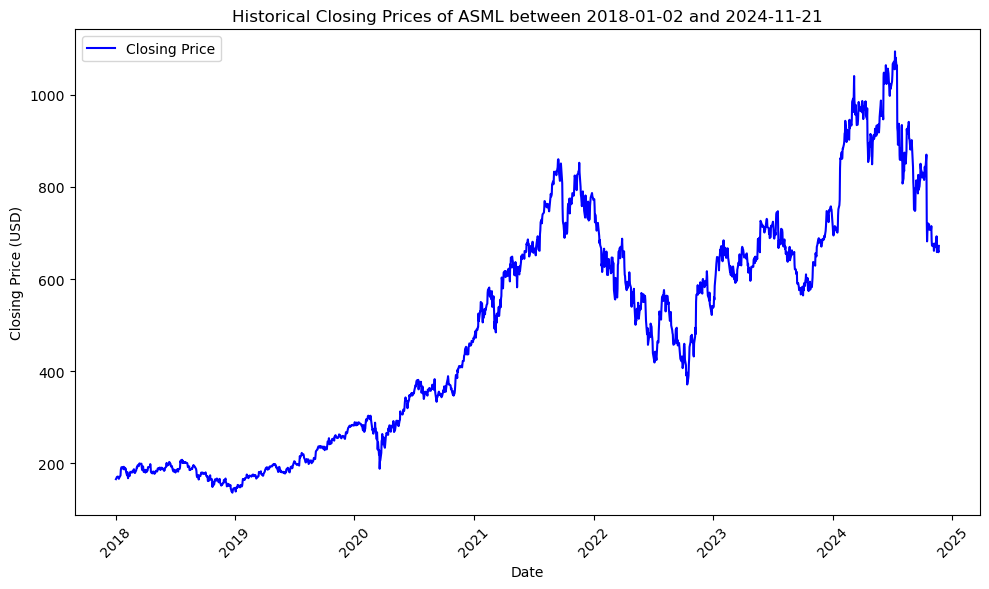

In [10]:
plot_closing_prices(historical_data, company_name)

### 2.5.2 Checking for duplicate values

In [11]:
historical_data.duplicated().sum()

0

There are no duplicated values. So we can continue

### 2.5.3 Checking for missing dates

In [12]:
(historical_data.isna().sum()/len(historical_data))*100

Date            0.0
Open            0.0
High            0.0
Low             0.0
Close           0.0
Volume          0.0
Dividends       0.0
Stock Splits    0.0
dtype: float64

As we can see there aren't any null values

Let's check the dates of the data

In [13]:
dates = create_daily_date_list(start_date, end_date)

date_range = pd.DataFrame(dates, columns=["Date"]) 

date_range

,Date
0,2018-01-01
1,2018-01-02
2,2018-01-03
3,2018-01-04
4,2018-01-05
...,...
2513,2024-11-18
2514,2024-11-19
2515,2024-11-20
2516,2024-11-21


In [14]:
# Ensure the 'Date' columns in both DataFrames are in datetime format for merging
historical_data['Date'] = pd.to_datetime(historical_data['Date']).dt.date
date_range['Date'] = pd.to_datetime(date_range['Date']).dt.date

# Perform the merge on the 'Date' column
merged_data = pd.merge(date_range, historical_data, on='Date', how='left')

merged_data

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-02,162.389805,165.840142,162.240597,165.737564,818600.0,0.0,0.0
2,2018-01-03,165.737577,167.462753,165.690948,166.996490,1054200.0,0.0,0.0
3,2018-01-04,168.311351,169.504981,167.294889,168.553802,915600.0,0.0,0.0
4,2018-01-05,168.637723,171.071612,168.553799,170.530746,516100.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2513,2024-11-18,651.070007,668.859985,648.000000,665.229980,2012600.0,0.0,0.0
2514,2024-11-19,662.820007,671.409973,653.469971,662.159973,1640700.0,0.0,0.0
2515,2024-11-20,656.530029,658.479980,645.450012,658.429993,1677800.0,0.0,0.0
2516,2024-11-21,653.919983,673.059998,649.020020,672.159973,2859000.0,0.0,0.0


We can see that there are null values because these are weekend dates. We are going to fill these null values doing a forward fill.

In [15]:
# Perform a forward fill to fill NaN values with the previous valid value
historical_data_complete = merged_data.fillna(method='ffill')

# Drop rows with NaN
historical_data_complete = historical_data_complete.dropna().reset_index(drop=True)

# Display the forward-filled DataFrame
historical_data_complete

C:\Users\Usuario\AppData\Local\Temp\ipykernel_22624\4287163570.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  historical_data_complete = merged_data.fillna(method='ffill')


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2018-01-02,162.389805,165.840142,162.240597,165.737564,818600.0,0.0,0.0
1,2018-01-03,165.737577,167.462753,165.690948,166.996490,1054200.0,0.0,0.0
2,2018-01-04,168.311351,169.504981,167.294889,168.553802,915600.0,0.0,0.0
3,2018-01-05,168.637723,171.071612,168.553799,170.530746,516100.0,0.0,0.0
4,2018-01-06,168.637723,171.071612,168.553799,170.530746,516100.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2512,2024-11-18,651.070007,668.859985,648.000000,665.229980,2012600.0,0.0,0.0
2513,2024-11-19,662.820007,671.409973,653.469971,662.159973,1640700.0,0.0,0.0
2514,2024-11-20,656.530029,658.479980,645.450012,658.429993,1677800.0,0.0,0.0
2515,2024-11-21,653.919983,673.059998,649.020020,672.159973,2859000.0,0.0,0.0


We will just keep columns: Data and Close

In [16]:
# Keep only the 'Date' and 'Close' columns
historical_data_complete = historical_data_complete[['Date', 'Close']]

# Display the resulting DataFrame
historical_data_complete

,Date,Close
0,2018-01-02,165.737564
1,2018-01-03,166.996490
2,2018-01-04,168.553802
3,2018-01-05,170.530746
4,2018-01-06,170.530746
...,...,...
2512,2024-11-18,665.229980
2513,2024-11-19,662.159973
2514,2024-11-20,658.429993
2515,2024-11-21,672.159973


### 2.5.4 Looking at seasonality

In [17]:
historical_data_complete.reset_index(inplace=True)

<Figure size 1200x800 with 0 Axes>

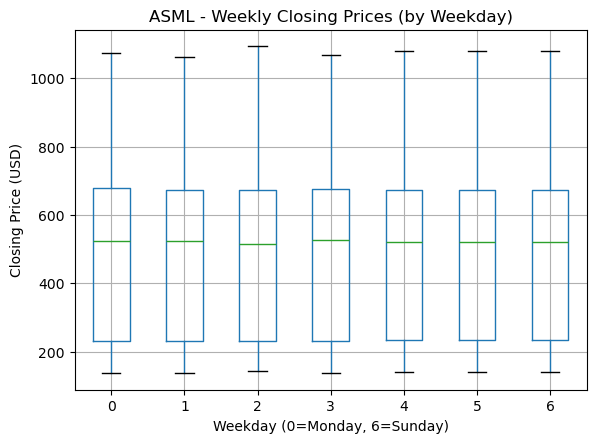

<Figure size 1200x800 with 0 Axes>

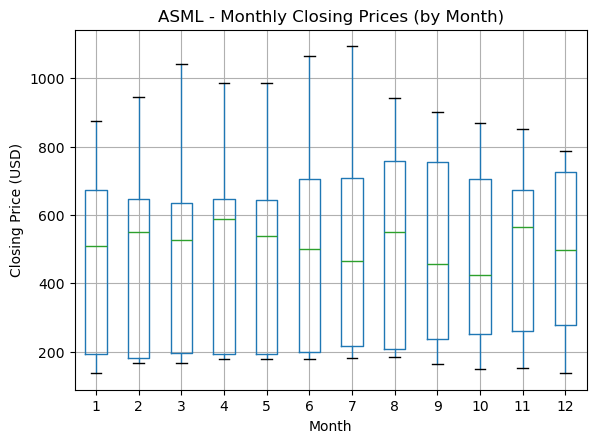

<Figure size 1200x800 with 0 Axes>

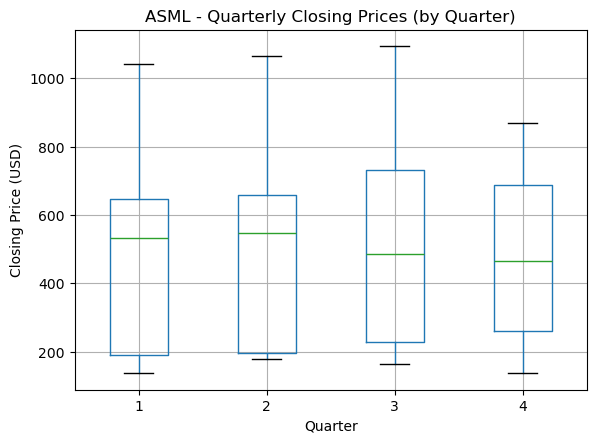

In [18]:
plot_stock_with_multiple_boxplots(historical_data_complete, company_name);

With the results above, we cannot determine if there is any clear seasonality. 

### 2.5.5 Choosing the time series of our dataset

Let's plot the time series doing different groubys to decide what we're going to work with. Having in mind our business case and the data points that we have.

Number of daily data points: 2517
Number of weekly data points: 360
Number of monthly data points: 83


C:\Users\Usuario\AppData\Local\Temp\ipykernel_22624\2504771402.py:26: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = historical_data.resample('M').median()


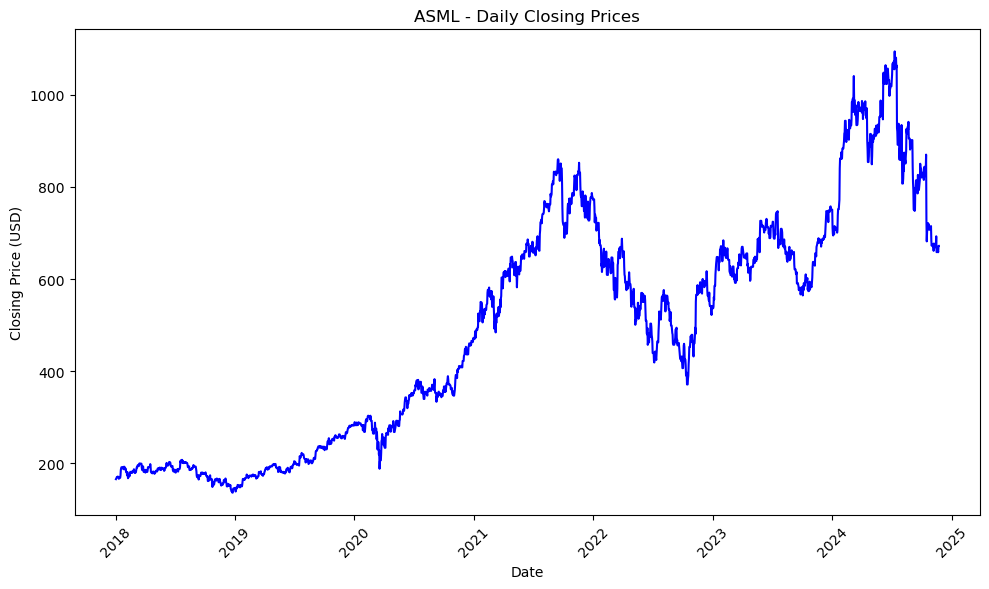

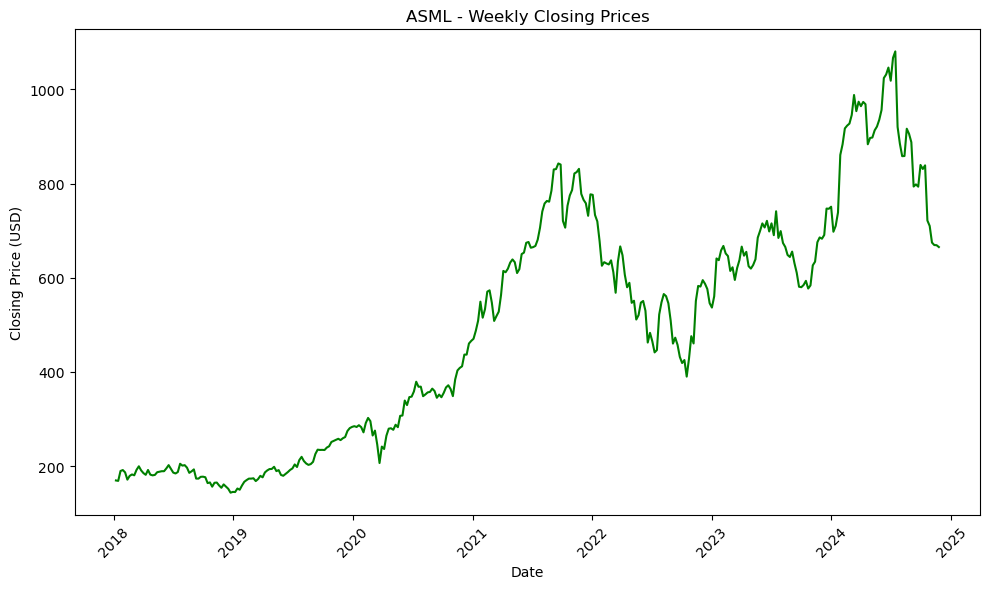

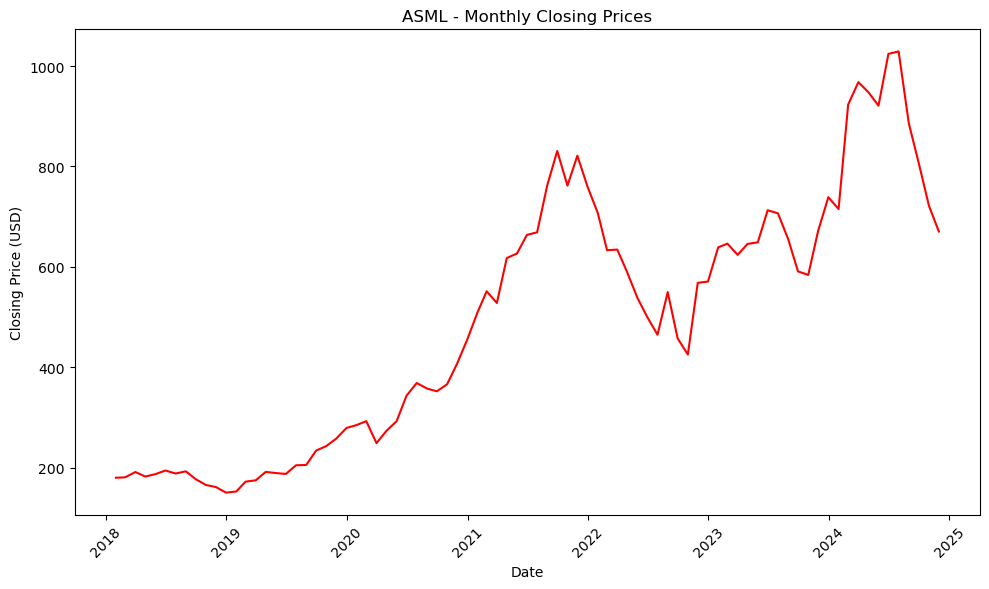

In [19]:
# Call function to plot the data
plot_stock_by_period(historical_data_complete, company_name)

We are going to transform the data. Based on out business case we are going to choose the weekly data because we want to give weekly predictions.

In [20]:
historical_data_complete

,index,Close,Weekday,Month,Quarter
Date,,,,,
2018-01-02,0,165.737564,1,1,1
2018-01-03,1,166.996490,2,1,1
2018-01-04,2,168.553802,3,1,1
2018-01-05,3,170.530746,4,1,1
2018-01-06,4,170.530746,5,1,1
...,...,...,...,...,...
2024-11-18,2512,665.229980,0,11,4
2024-11-19,2513,662.159973,1,11,4
2024-11-20,2514,658.429993,2,11,4


We are going to eliminate the week end date to avoid distorsions on the weekly data calculus

In [21]:
# Filter the dataframe to exclude weekends
historical_data_complete = historical_data_complete[historical_data_complete.index.weekday < 5]

In [22]:
historical_data_complete

,index,Close,Weekday,Month,Quarter
Date,,,,,
2018-01-02,0,165.737564,1,1,1
2018-01-03,1,166.996490,2,1,1
2018-01-04,2,168.553802,3,1,1
2018-01-05,3,170.530746,4,1,1
2018-01-08,6,171.425995,0,1,1
...,...,...,...,...,...
2024-11-18,2512,665.229980,0,11,4
2024-11-19,2513,662.159973,1,11,4
2024-11-20,2514,658.429993,2,11,4


In [23]:
# Set 'Date' as the DataFrame index
# historical_data_complete.set_index('Date', inplace=True)
weekly_data = historical_data_complete.resample('W').median()

In [24]:
weekly_data = weekly_data[['Close']]
weekly_data

,Close
Date,
2018-01-07,167.775146
2018-01-14,168.665665
2018-01-21,185.740250
2018-01-28,191.568481
2018-02-04,187.829102
...,...
2024-10-27,710.051941
2024-11-03,683.830017
2024-11-10,671.159973


We are going to continue investigating the EDA

### 2.5.6 Seasonal-Trend-Loess Decomposition (STL)

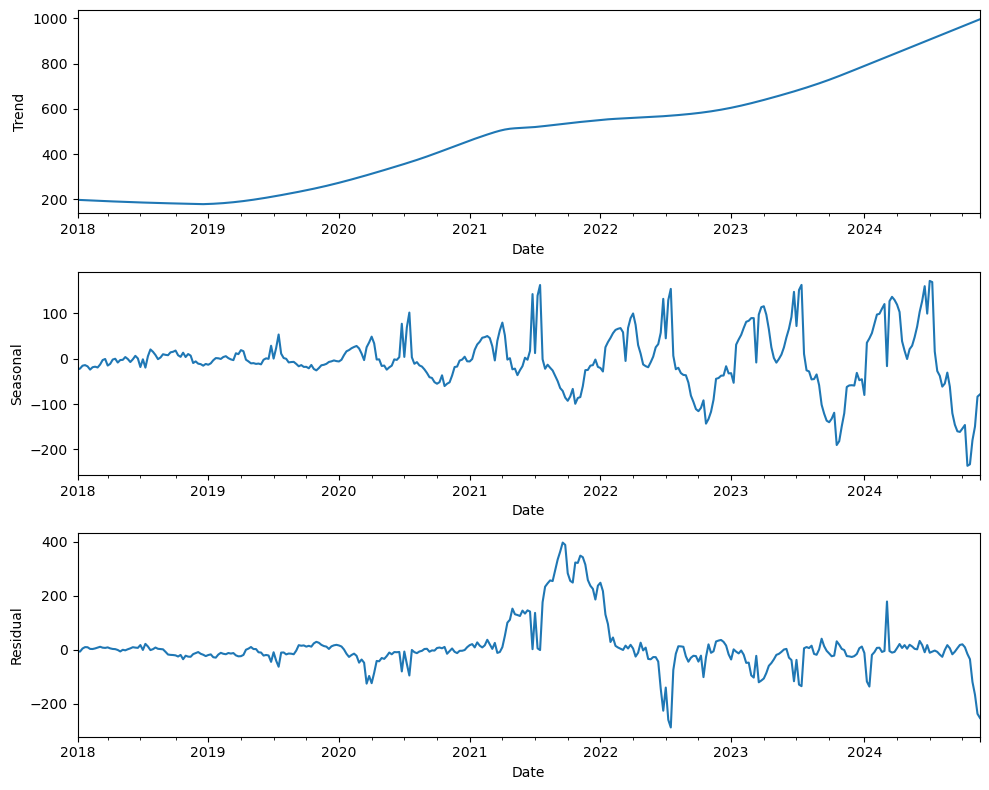

In [25]:
# Perform STL decomposition on the 'Close' prices
stl = STL(weekly_data['Close'], period=52, robust=True)
result = stl.fit()

# Plot the decomposed components
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8))
result.trend.plot(ax=ax1)
ax1.set_ylabel('Trend')
result.seasonal.plot(ax=ax2)
ax2.set_ylabel('Seasonal')
result.resid.plot(ax=ax3)
ax3.set_ylabel('Residual')
plt.tight_layout()
plt.show()

The STL decomposition shown in the images provides valuable insights into the stock's time series data.

1. **Trend Component**: The trend shows a steady and accelerating increase in the stock price over time, particularly after 2019. The sharp rise starting around 2020 indicates a significant upward movement, reflecting overall growth in the stock's value.

2. **Seasonal Component**: The seasonal fluctuations become more pronounced after 2019, indicating increased volatility in the stock price. The pattern of these fluctuations is relatively stable until 2019, after which the amplitude increases. This could suggest stronger cyclical patterns or market reactions during this period.

3. **Residual Component**: The residual plot highlights that the deviations from the trend and seasonality were relatively low and stable up until 2020. However, starting in 2020, the residuals become much more volatile, with significant fluctuations. This indicates that there were external factors or events during and after 2020 that caused irregularities and deviations from the expected trend and seasonal patterns, such as market disruptions or other unpredictable events.

In conclusion, while the stock price follows a clear upward trend, both seasonality and residual volatility increase significantly after 2020, indicating a period of heightened uncertainty or external shocks affecting the stock's behavior. This could align with broader market or global events, such as the COVID-19 pandemic.

### 2.5.7 Autocorrelation and Partial Autocorrelation (ACF/PACF)

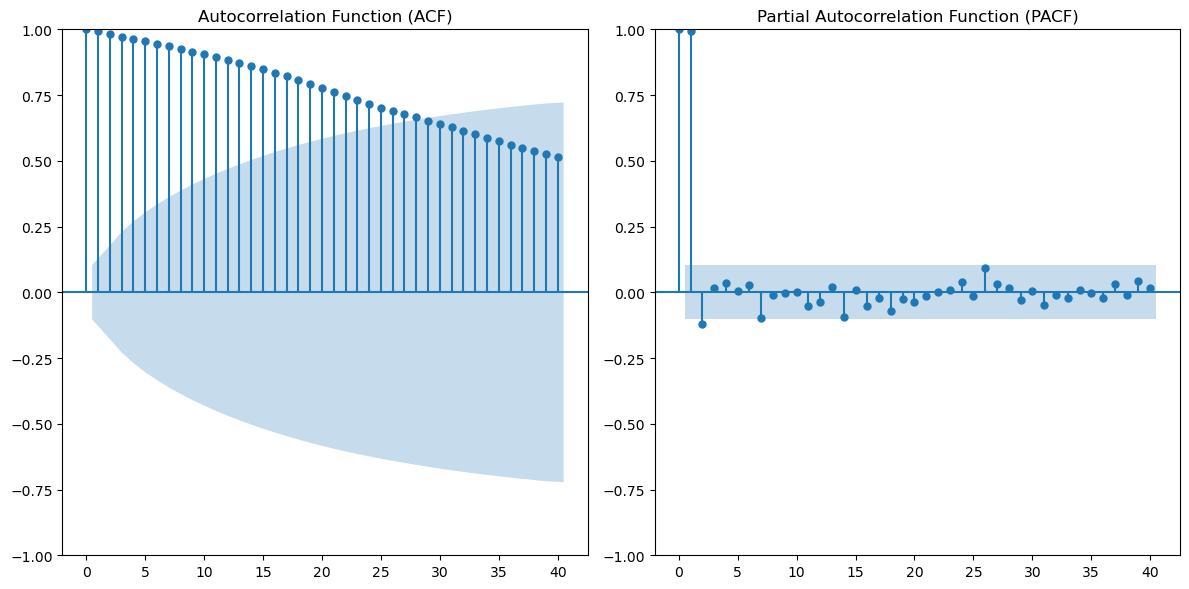

In [26]:
plt.figure(figsize=(12, 6))

# Plot Autocorrelation Function (ACF)
plt.subplot(121)
plot_acf(weekly_data, lags=40, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')

# Plot Partial Autocorrelation Function (PACF)
plt.subplot(122)
plot_pacf(weekly_data, lags=40, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

The Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots reveal important information about the time series:

1. **ACF (Autocorrelation Function)**:
    - The ACF plot shows high autocorrelation at many lags, with a slow decline as the number of lags increases. This suggests that the time series has strong autocorrelation over time, meaning the values of the series are highly dependent on previous observations.
    - The slow decay indicates that the series might follow a non-stationary process, potentially requiring differencing to stabilize the mean before further modeling (as in ARIMA models).
    - This pattern could also suggest that the series has a long-term trend or seasonality that hasn't been fully accounted for.


2. **PACF (Partial Autocorrelation Function)**:
    - The PACF plot shows a sharp cut-off after the first lag, with only a few significant partial autocorrelations at later lags.
    - This suggests that the time series is well explained by an autoregressive (AR) process of low order, meaning past values are influencing the current value up to a certain point, but after that, the effect diminishes significantly.
    - The sharp drop after the first lag could point to a possible AR(1) process, where the first lag has the most predictive power.

**Conclusion**:

The time series exhibits strong autocorrelation over many lags, which may indicate non-stationarity or the presence of a trend. The PACF suggests that an autoregressive model of low order (possibly AR(1)) could be a good fit for the data. Depending on the modeling approach, differencing might be necessary to address non-stationarity, and an ARIMA model could be a candidate for forecasting.

### 2.5.8 Rolling Statistics

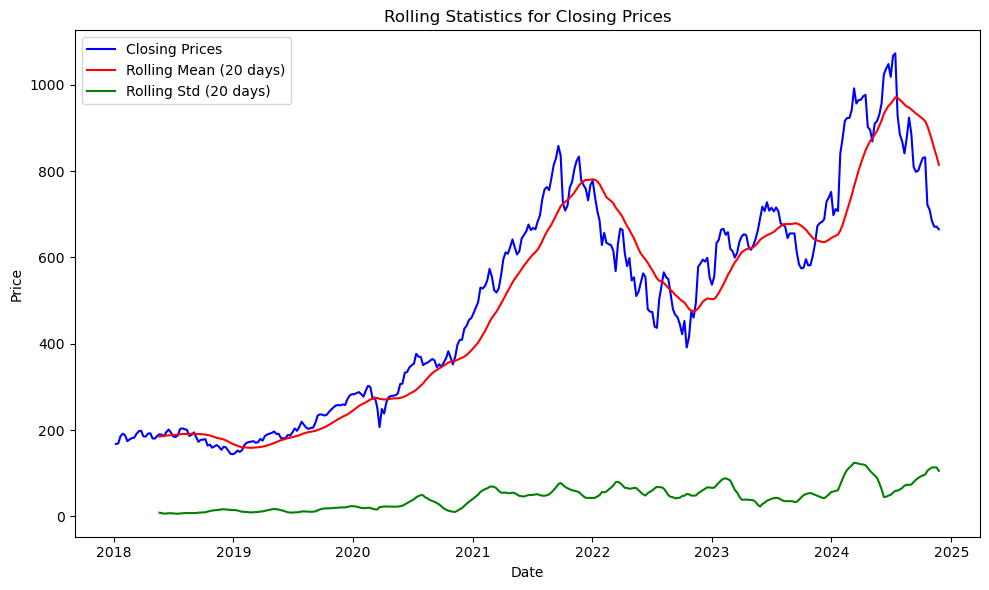

In [27]:
# Calculate rolling mean and standard deviation (rolling window of 20 days)
rolling_mean = weekly_data['Close'].rolling(window=20).mean()
rolling_std = weekly_data['Close'].rolling(window=20).std()

# Plot the closing prices and rolling statistics
plt.figure(figsize=(10, 6))
plt.plot(weekly_data['Close'], label='Closing Prices', color='blue')
plt.plot(rolling_mean, label='Rolling Mean (20 days)', color='red')
plt.plot(rolling_std, label='Rolling Std (20 days)', color='green')

# Adding labels and title
plt.title('Rolling Statistics for Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

The stock has experienced strong long-term growth with periods of heightened volatility, particularly after 2020. The moving average shows an overall upward trajectory, suggesting that the stock has been a good performer over time. However, the recent price drop in 2024, combined with high volatility, indicates that the stock may be entering a period of uncertainty, and it will be important to monitor if the stock can recover from this latest decline as it has done in the past.

### 2.5.9 Distribution of Returns

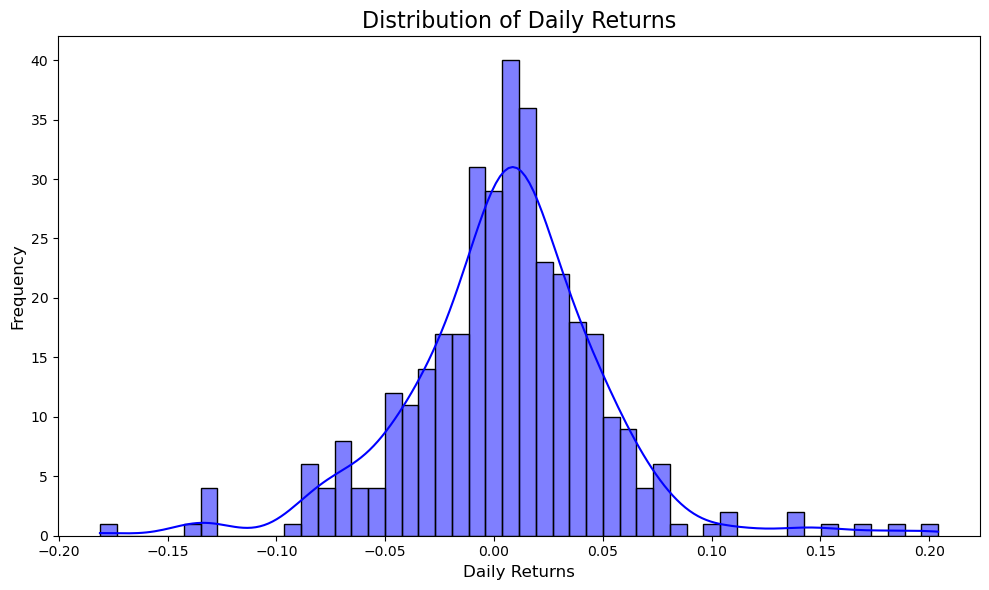

In [28]:
# Step 1: Calculate daily returns
# The pct_change() function calculates the percentage change between the current and prior element.
# This will give us the daily returns as a percentage change of closing prices.
weekly_data['Returns'] = weekly_data['Close'].pct_change()

# Step 2: Drop NaN values that appear after the pct_change() calculation
# NaN values result from the first row since there is no previous data point to compare with.
weekly_data.dropna(subset=['Returns'], inplace=True)

# Step 3: Plotting the distribution of daily returns using a histogram
plt.figure(figsize=(10, 6))
sns.histplot(weekly_data['Returns'], bins=50, kde=True, color='blue')

# Adding titles and labels
plt.title('Distribution of Daily Returns', fontsize=16)
plt.xlabel('Daily Returns', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

The distribution of daily returns shows a normal-like shape centered around zero, indicating that most returns are close to neutral. However, there is a slight positive skew, suggesting that small positive returns are more frequent than negative ones. The long right tail highlights the occurrence of occasional large positive returns, while the left tail shows some infrequent but larger negative returns. This pattern suggests that the stock typically experiences small, stable gains with occasional volatile movements. Investors should be aware of both the potential for moderate losses and occasional larger gains.

### 2.5.10 Outlier Detection

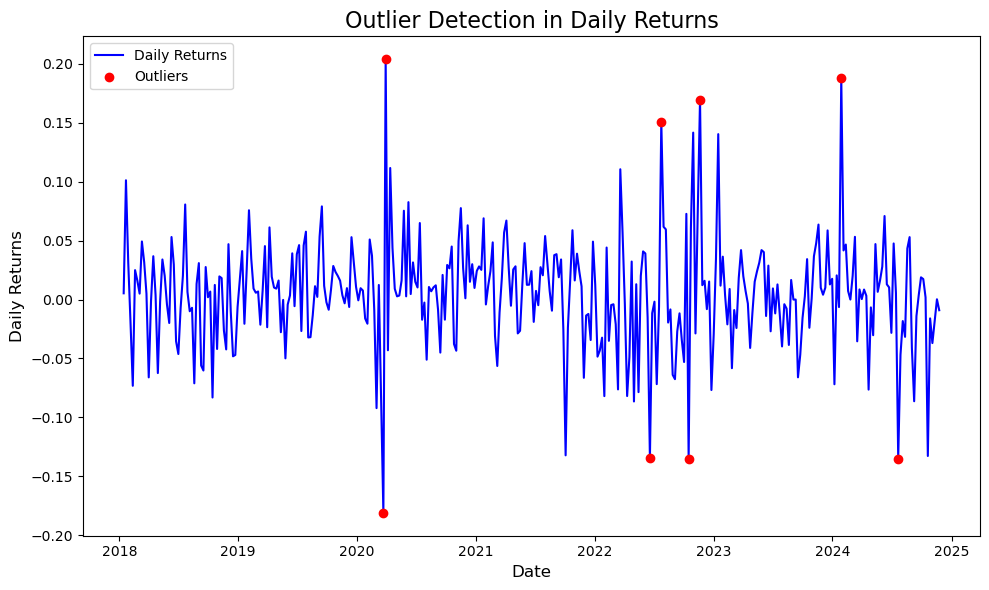

Number of Outliers Detected: 8
             Returns   Z_score
Date                          
2020-03-22 -0.181160 -4.037262
2020-03-29  0.204118  4.322706
2022-06-19 -0.134411 -3.022866
2022-07-24  0.150802  3.165818
2022-10-16 -0.135414 -3.044627
2022-11-20  0.169662  3.575052
2024-01-28  0.188007  3.973102
2024-07-21 -0.134891 -3.033282


In [29]:
# Step 1: Calculate the z-scores of the returns
# Z-score measures how far each data point is from the mean, expressed in terms of standard deviations
# Returns with a z-score higher than a certain threshold (e.g., 3 or -3) are considered outliers
weekly_data['Z_score'] = (weekly_data['Returns'] - weekly_data['Returns'].mean()) / weekly_data['Returns'].std()

# Step 2: Define a threshold for outliers (commonly used threshold is 3 standard deviations)
threshold = 3

# Step 3: Identify outliers
# Outliers are returns with z-scores greater than the threshold or less than the negative threshold
outliers = weekly_data[np.abs(weekly_data['Z_score']) > threshold]

# Step 4: Plot the returns and highlight the outliers
plt.figure(figsize=(10, 6))

# Plot all returns
plt.plot(weekly_data.index, weekly_data['Returns'], label='Daily Returns', color='blue')

# Highlight the outliers in red
plt.scatter(outliers.index, outliers['Returns'], color='red', label='Outliers', zorder=5)

# Adding labels and title
plt.title('Outlier Detection in Daily Returns', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Daily Returns', fontsize=12)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

# Step 5: Print the outliers for review
print(f"Number of Outliers Detected: {len(outliers)}")
print(outliers[['Returns', 'Z_score']])

The chart highlights several significant outliers (in red) among the daily returns, where the stock experienced unusually large price movements beyond what would be considered typical. The most prominent outlier occurred around 2012, with a large spike in returns, indicating an exceptional event that caused a sharp price increase. Additionally, there are multiple outliers around 2020 and 2022, both on the positive and negative side, reflecting high volatility during these periods, likely due to global events such as the COVID-19 pandemic and its market impacts. The outliers in 2024 suggest recent instability, possibly driven by significant market or company-specific events. These anomalies highlight periods of market disruption or unexpected events, which require further investigation to understand the underlying causes.

### 2.5.11 Correlation with External Factors

[*********************100%***********************]  1 of 1 completed

Correlation between Stock Returns and S&P 500 Weekly Returns:
                Returns  SP500_Returns
Returns        1.000000       0.568163
SP500_Returns  0.568163       1.000000


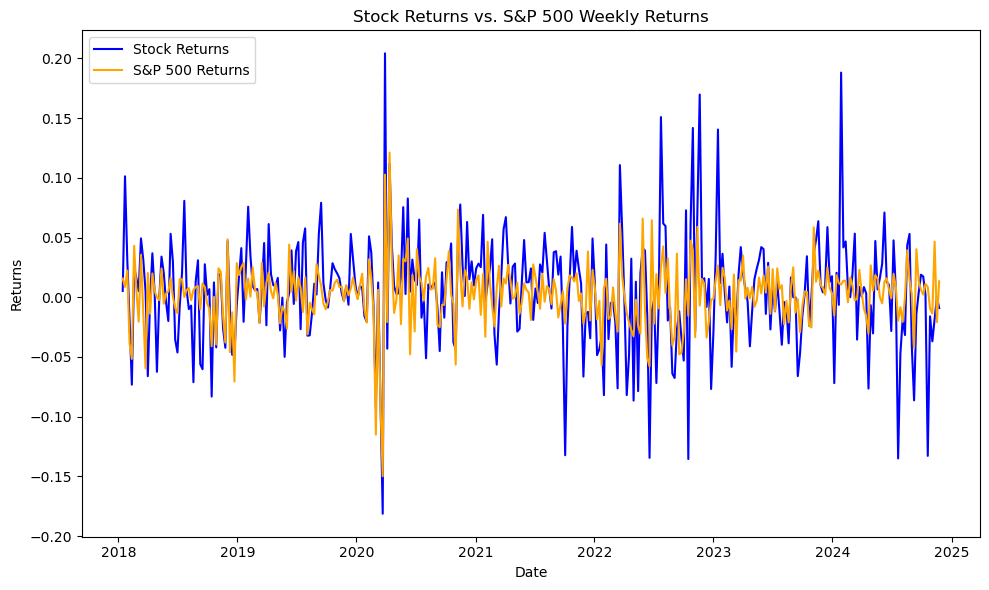

In [30]:
# Step 1: Download S&P 500 index data from Yahoo Finance (still daily data)
sp500 = yf.download('^GSPC', start=start_date, end=end_date)

# Step 2: Resample S&P 500 data to weekly frequency and calculate weekly returns
# Resample S&P 500 data to weekly and use the closing price of each week
sp500_weekly = sp500['Close'].resample('W').last()  # Using 'last' to get the price at the end of the week

# Calculate weekly returns for the S&P 500
sp500_weekly_returns = sp500_weekly.pct_change()

# Step 3: Merge both datasets (weekly stock returns and weekly S&P 500 returns) on the date index
# Ensure 'weekly_data' contains the weekly stock returns ('Returns') and is resampled to a weekly frequency.
merged_data = pd.merge(weekly_data[['Returns']], sp500_weekly_returns.rename('SP500_Returns'), 
                       left_index=True, right_index=True, how='inner')

# Step 4: Calculate the correlation between stock returns and S&P 500 weekly returns
correlation = merged_data.corr()

# Step 5: Output the correlation result
print("Correlation between Stock Returns and S&P 500 Weekly Returns:")
print(correlation)

# Step 6: Plot the returns to visualize their relationship
plt.figure(figsize=(10, 6))

# Plot the stock returns
plt.plot(merged_data.index, merged_data['Returns'], label='Stock Returns', color='blue')

# Plot the S&P 500 weekly returns
plt.plot(merged_data.index, merged_data['SP500_Returns'], label='S&P 500 Returns', color='orange')

# Add titles and labels
plt.title('Stock Returns vs. S&P 500 Weekly Returns')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


The plot shows the weekly returns of the stock (in blue) compared with the S&P 500's weekly returns (in orange). The two series generally move in the same direction, indicating some degree of correlation between the stock and the overall market. However, the stock exhibits higher volatility, with more pronounced spikes in both positive and negative returns compared to the S&P 500, especially during certain periods (e.g., around 2012 and 2020). This suggests that while the stock follows broader market trends, it also experiences more significant price swings. The correlation between the two indicates that the stock is influenced by market movements, but it also displays unique factors that lead to larger deviations from the market index.

# 3. Export the data

In [31]:
# We just want the "Close" column
weekly_data_asml = weekly_data.drop(['Z_score','Returns'], axis=1)

# Export the weekly_data to a CSV file
weekly_data_asml.to_csv(output_data, index=True, sep=';')

Save the start_data and test_weeks variables

In [32]:
# Save the variables using pickle
with open(start_data_and_test_weeks_path, 'wb') as f:
    pickle.dump({'start_date': start_date, 'test_weeks': test_weeks}, f)